# Regression

## Objectives

*   Find a regressor machine learning model to predict house sale prices if the features describing the house are known.


## Inputs

* outputs/datasets/collection/HousePricesRecords.csv
* Feature engineering/ datacleaning pipeline from the FeatureEngineering Jupyter notebook 

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale prices
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

---

# Load Data

In [53]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv"))
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500.0


# ML Pipeline for Regressor

## Create ML pipeline

We need our custom encoder from the FeatureEngineering notebook

In [16]:
### Custom Encoder
from sklearn.base import BaseEstimator, TransformerMixin
class MyCustomEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, variables, dic):
    if not isinstance(variables, list): 
      self.variables = [variables]
    else: self.variables = variables
    self.dic = dic

  def fit(self, X, y=None):    
    return self

  def transform(self, X):
    for col in self.variables:
      if X[col].dtype == 'object':
        X[col] = X[col].replace(dic[col])
      else:
        print(f"Warning: {col} data type should be object to use MyCustomEncoder()")
      
    return X

### Pipeline from the FeatureEngineering notebook where we add feature scaling, feature selection and model (as parameter):

In [17]:
from sklearn.pipeline import Pipeline

### Drop features
from feature_engine.selection import DropFeatures

### Median Imputer
from feature_engine.imputation import MeanMedianImputer

### Correlation selection
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),
            
            ('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dic=dic)),
            
            ('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            
            ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),
            
            ("feat_scaling", StandardScaler() ),

            ("feat_selection",  SelectFromModel(model) ),

            ("model", model ),
      ])

      return pipeline

### Custom Class for hyperparameter Optimization: (From Code Institute Scikit lesson)

In [18]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, dic, vars_with_missing_data, models, params):
        self.dic = dic
        self.vars_with_missing_data = vars_with_missing_data
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(dic, vars_with_missing_data, self.models[key],)

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split the data in Train and Test Set

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

### Try seven ML algorithms with default hyperparameters

In [20]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [21]:
# Dictionary for MyCustomEncoder
dic = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, 'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}

# Variables with missing variables after dropping ['EnclosedPorch', 'WoodDeckSF']. This is a parameter passed to MeanMedianImputer
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']     


### Train five models (one for each of the five crossvalidations, cv=5) for each algoritm, and default hyperparameters.

In [22]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Check results

In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.800495,0.867736,0.0730919
2,RandomForestRegressor,0.632989,0.791839,0.85964,0.0836853
0,LinearRegression,0.701462,0.77925,0.824712,0.0413626
5,GradientBoostingRegressor,0.639305,0.763939,0.850056,0.0838745
6,XGBRegressor,0.637822,0.738218,0.821103,0.0700405
4,AdaBoostRegressor,0.621051,0.721318,0.794948,0.0639857
1,DecisionTreeRegressor,0.495511,0.623105,0.674645,0.067497


### Conduct hyperparameter optimization on the top four models using hyperparameter combinations from Code Institute Scikit lesson

In [24]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    "LinearRegression":{},
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    }
}

Train models with GridSearchCV, in total 1625 models

In [25]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


### Check results

In [26]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(5)

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
132,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.0323807,3,50,50,140,50,0.1
129,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.0323807,3,50,2,140,50,0.1
120,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.0323807,3,50,50,140,None,0.1
117,GradientBoostingRegressor,0.76362,0.812701,0.851956,0.0323807,3,50,2,140,None,0.1
130,GradientBoostingRegressor,0.762197,0.812534,0.850881,0.0326965,3,50,50,100,50,0.1


Access best algorithm

In [27]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Access best model parameters

In [28]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

Access best pipeline

In [29]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      '...
    

## Assess feature importance
Code from Code Institute Scikit lesson

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


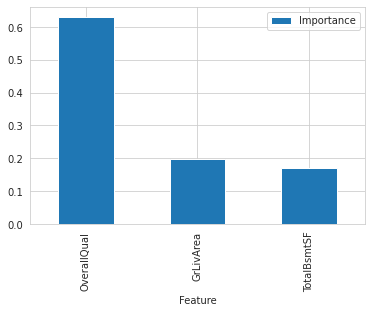

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets
Code from Code Institute Scikit lesson

In [31]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].tick_params(axis='x', rotation=90)
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].tick_params(axis='x', rotation=90)
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

### Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24327.455
Mean Squared Error: 1648795357.104
Root Mean Squared Error: 40605.361




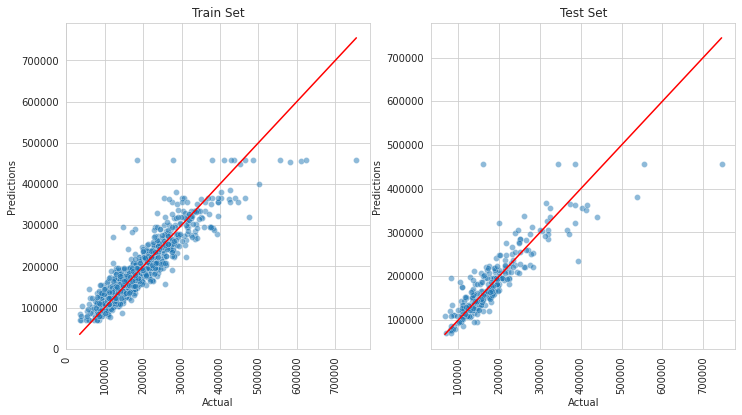

In [32]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### The R2 score on the test set is 0.76 and passes the performance goal of an R2 score of at least 0.75. See business case assessment in README file.

# Refit pipeline with best features

## Rewrite Pipeline

The previous pipeline is trained on only three features out of 23. Therefore we update the pipeline, training set and test set so that the model becomes smaller and therefore more efficient. The features are:

In [33]:
best_features

['GrLivArea', 'OverallQual', 'TotalBsmtSF']

These features do not need encoding and they have no missing data. No feature selection is required since it is already done. The pipeline consists of only two steps.

In [34]:
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea']

In [35]:
def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            #('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),
            
            #('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dic=dic)),
            
            #('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            
            #('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),
            
            ("feat_scaling", StandardScaler() ),

            #("feat_selection",  SelectFromModel(model) ),

            ("model", model ),
      ])

      return pipeline

## Update Train and Test Sets

In [36]:
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Keep only the three best features in the train and test set

In [37]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 3) (1168,) 
* Test set: (292, 3) (292,)


,GrLivArea,OverallQual,TotalBsmtSF
618,1828.0,9,1822.0
870,894.0,5,894.0
92,964.0,5,876.0


## Grid Search CV – Sklearn

### We use the best model (algorithm and hyperparameters) from the previous section:

In [38]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [39]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

### Update the corresponding variables:

In [40]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{'model__n_estimators': [140],
                                 'model__learning_rate': [0.1],
                                 'model__max_depth': [3],
                                 'model__min_samples_split': [2],
                                 'model__min_samples_leaf': [50],
                                 'model__max_leaf_nodes': [None],
    }
}

### Train models with GridSearchCV

In [41]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Check results

In [42]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.763173,0.79923,0.830174,0.0295447,0.1,3,None,50,2,140


### Access best pipeline

In [43]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(min_samples_leaf=50,
                                           n_estimators=140, random_state=0))])

## Assess feature importance

### The result is the same as in the previous section because the regressor is in fact the same, being trained on the same data'

* These are the 3 features showed in order of importance (descending order). 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


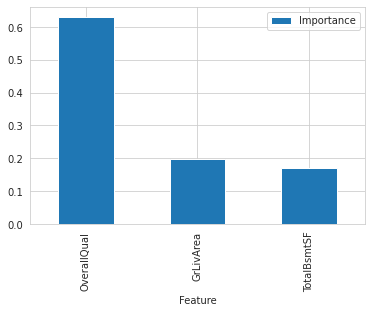

In [44]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': X_train.columns,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Features statement and plot
print(f"* These are the {len(X_train.columns)} features showed in order of importance (descending order). "
      f"\n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate performance

### The results are the same as in the previous section because the regressor is in fact the same, being trained on the same data

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24327.455
Mean Squared Error: 1648795357.104
Root Mean Squared Error: 40605.361




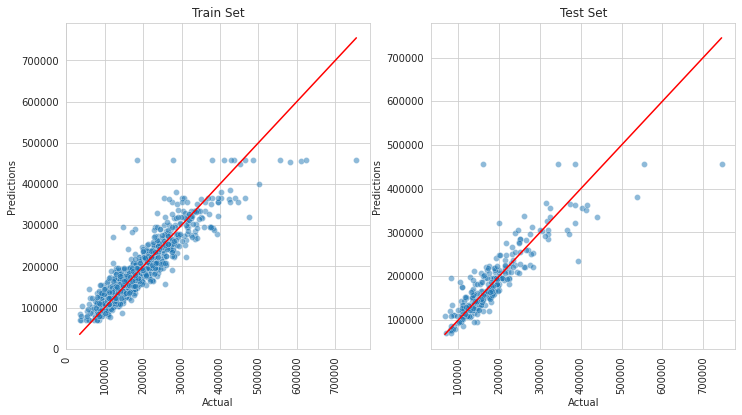

In [45]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Create files for the dashboard

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [50]:
import joblib
import os

version = 'v1'
file_path = f'outputs/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set : features and target

In [51]:
X_train.head()

,GrLivArea,OverallQual,TotalBsmtSF
618,1828.0,9,1822.0
870,894.0,5,894.0
92,964.0,5,876.0
817,1689.0,8,1568.0
302,1541.0,7,1541.0


In [52]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [53]:
y_train.head()

618    314813.0
870    109500.0
92     163500.0
817    271000.0
302    205000.0
Name: SalePrice, dtype: float64

In [54]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [55]:
X_test.head()

,GrLivArea,OverallQual,TotalBsmtSF
529,2515.0,6,2035.0
491,1578.0,6,806.0
459,1203.0,5,709.0
279,2022.0,7,1160.0
655,1092.0,6,525.0


In [56]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [57]:
y_test.head()

529    200624.0
491    133000.0
459    110000.0
279    192000.0
655     88000.0
Name: SalePrice, dtype: float64

In [58]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting sale price

In [59]:
best_regressor_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(min_samples_leaf=50,
                                           n_estimators=140, random_state=0))])

In [60]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/predict_price/v1/best_regressor_pipeline.pkl']

## Feature importance plot

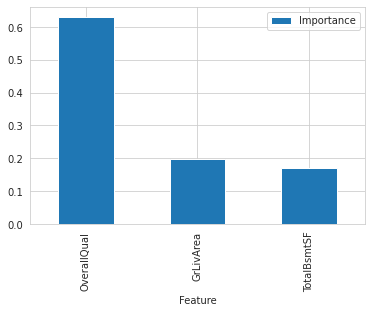

In [61]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

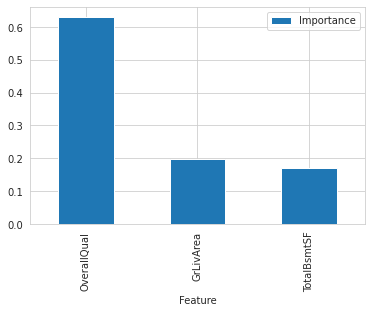

In [62]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---